In [1]:
import os
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model

In [2]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
import glob
import random

images = glob.glob('./imagenet_/**/*.jpg')

random.shuffle(images)

images = images[:1000]

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
features = []
for i, image_path in enumerate(images):
    if i % 10 == 0:
        print("analyzed " + str(i) + " out of " + str(len(images)))
    
    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

analyzed 0 out of 1000
analyzed 10 out of 1000
analyzed 20 out of 1000
analyzed 30 out of 1000
analyzed 40 out of 1000
analyzed 50 out of 1000
analyzed 60 out of 1000
analyzed 70 out of 1000
analyzed 80 out of 1000
analyzed 90 out of 1000
analyzed 100 out of 1000
analyzed 110 out of 1000
analyzed 120 out of 1000
analyzed 130 out of 1000
analyzed 140 out of 1000
analyzed 150 out of 1000
analyzed 160 out of 1000
analyzed 170 out of 1000
analyzed 180 out of 1000
analyzed 190 out of 1000
analyzed 200 out of 1000
analyzed 210 out of 1000
analyzed 220 out of 1000
analyzed 230 out of 1000
analyzed 240 out of 1000
analyzed 250 out of 1000
analyzed 260 out of 1000
analyzed 270 out of 1000
analyzed 280 out of 1000
analyzed 290 out of 1000
analyzed 300 out of 1000
analyzed 310 out of 1000
analyzed 320 out of 1000
analyzed 330 out of 1000
analyzed 340 out of 1000
analyzed 350 out of 1000
analyzed 360 out of 1000
analyzed 370 out of 1000
analyzed 380 out of 1000
analyzed 390 out of 1000
analyzed 40

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

ss = StandardScaler()
scaled = ss.fit_transform(features)

In [8]:
sum_squared = []

K = range(1, 30)

for i in K:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled)
    sum_squared.append(kmeans.inertia_)

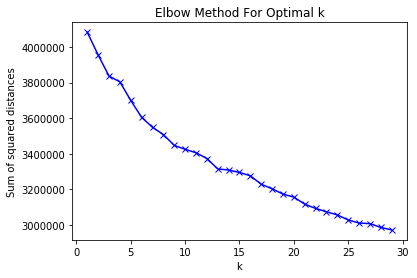

In [9]:
plt.plot(K, sum_squared, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show() 

In [10]:
kmeans = KMeans(n_clusters=14)
clusters = kmeans.fit_predict(scaled)

In [11]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5, metric='cosine').fit(scaled)
_, closest = neighbors.kneighbors(kmeans.cluster_centers_)

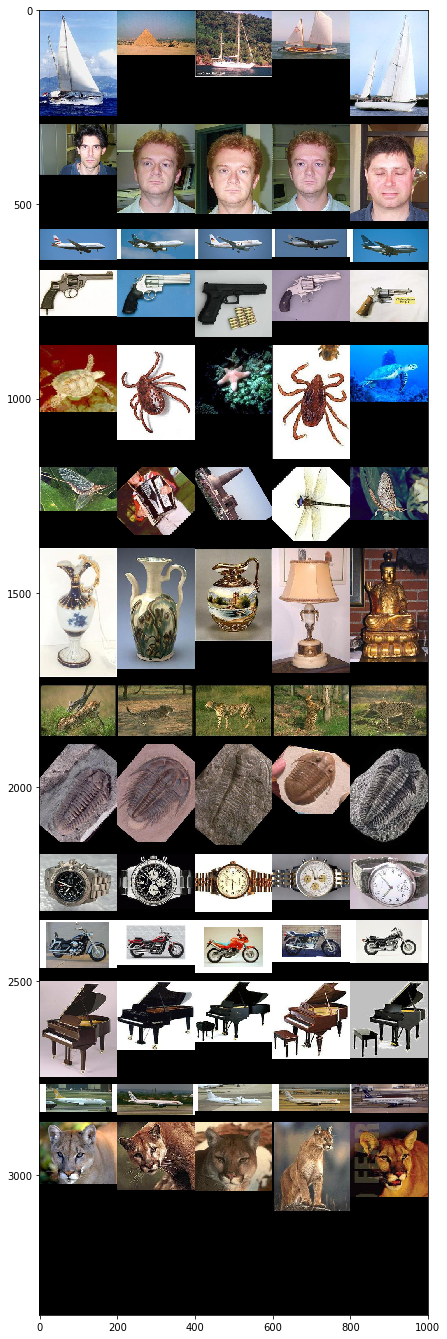

In [13]:
from PIL import Image

img_width = 200

grid_image = Image.new('RGB', (5 * img_width, len(closest) * 240), (0, 0, 0, 255))

max_height = 0
for cluster_row in closest:
    max_height_temp = 0
    xpos = 0
    for col_num in cluster_row:
        img = Image.open(images[col_num])
        img_ar = img.width / img.height
        img = img.resize((img_width, int(img_width / img_ar)), Image.ANTIALIAS)
        max_height_temp = max(max_height_temp, img.height)
        grid_image.paste(img, (xpos, max_height))
        xpos = xpos + img.width
    max_height = max_height + max_height_temp + 20 # adding 20 pixel margin

plt.figure(figsize = (32,24))
plt.imshow(grid_image)

In [14]:
import umap

embedding = umap.UMAP().fit_transform(scaled)

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(embedding)
embedding_scaled = scaler.transform(embedding)

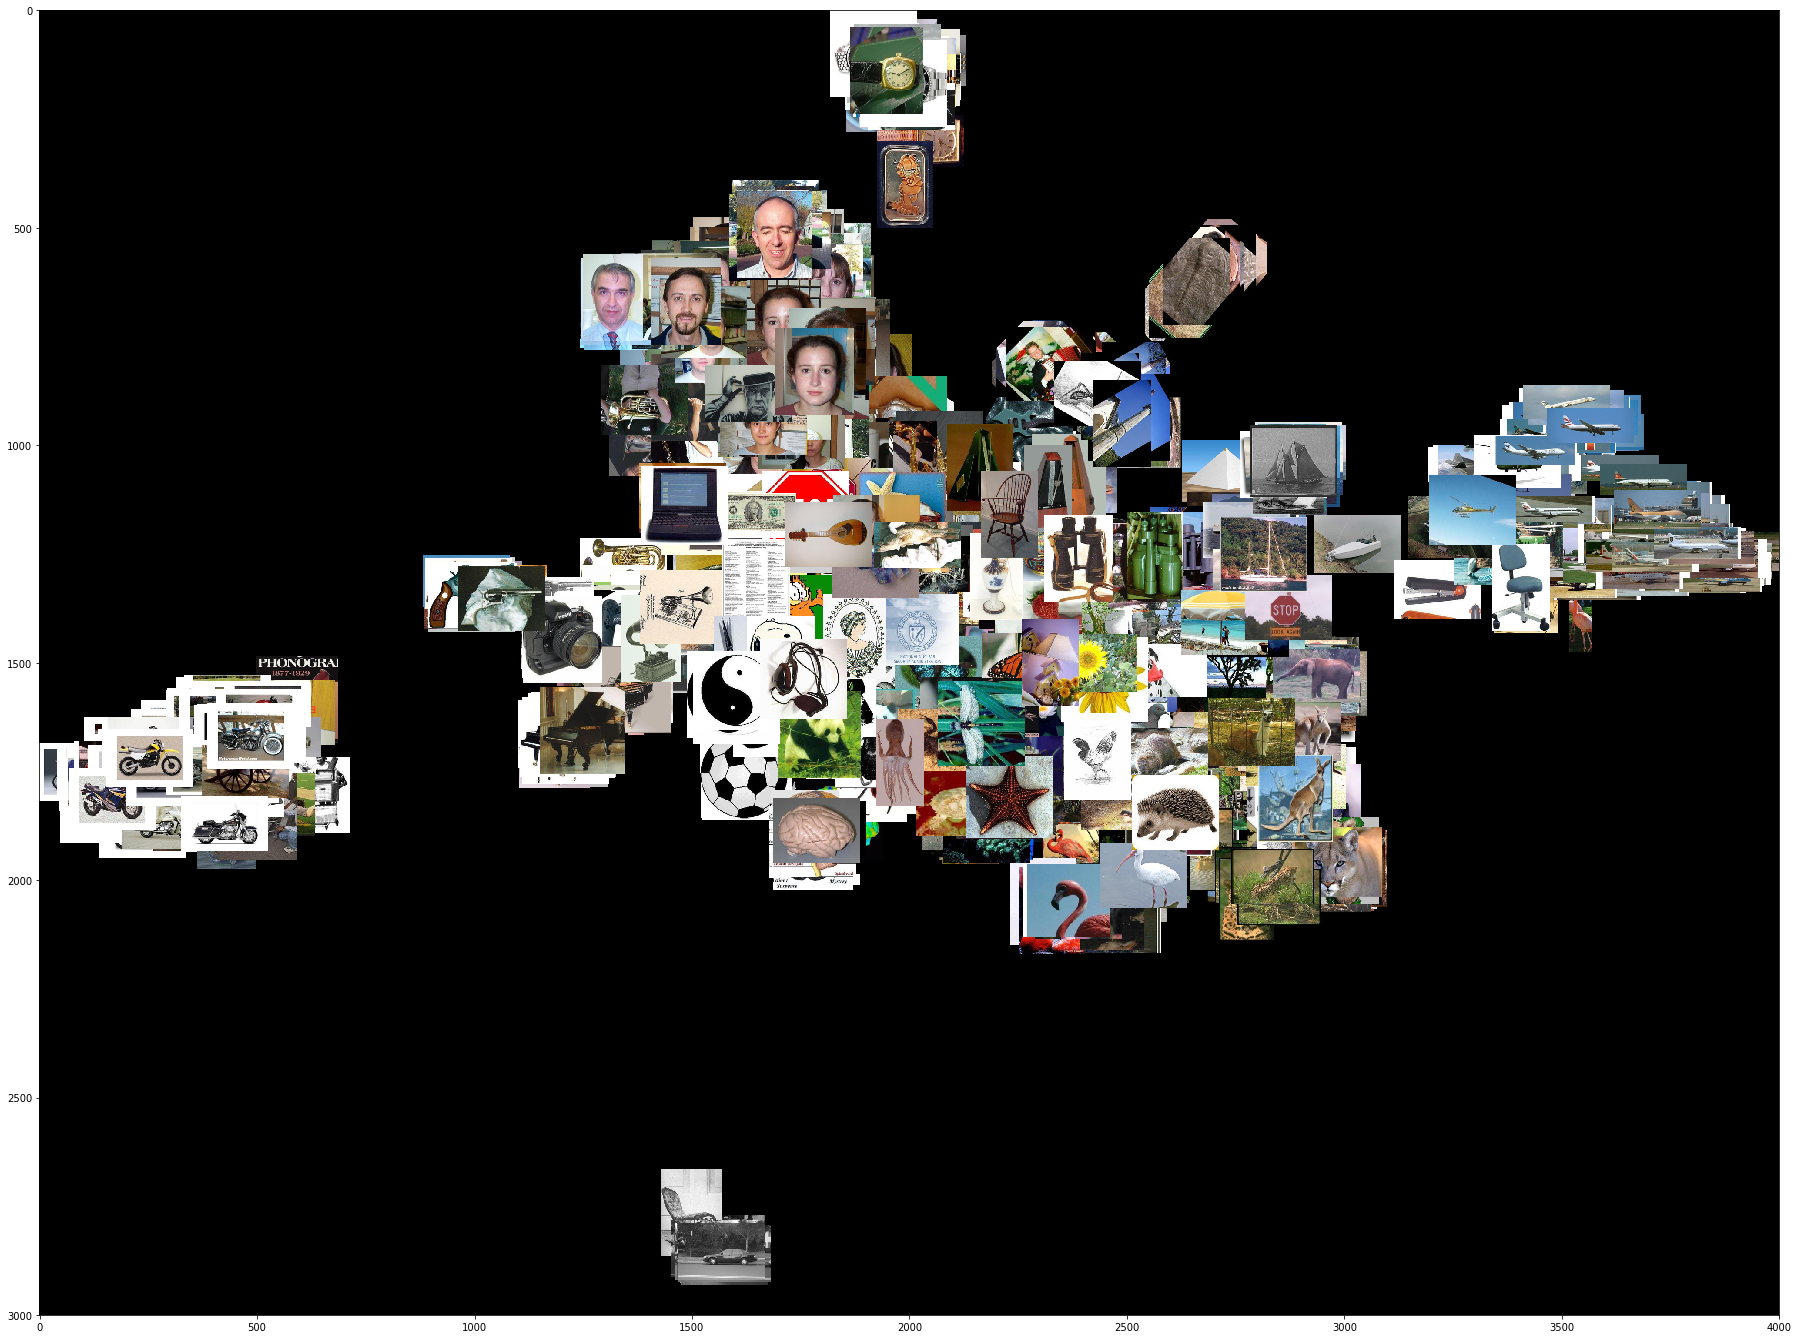

In [16]:
width = 4000
height = 3000
max_dim = 200

full_image = Image.new('RGBA', (width, height), (0, 0, 0, 255))
for img, pos in zip(images, embedding_scaled):
    x = pos[0]
    y = pos[1]
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (32,24))
plt.imshow(full_image)

In [17]:
import rasterfairy

nx = 40
ny = 25

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(embedding, target=(nx, ny))

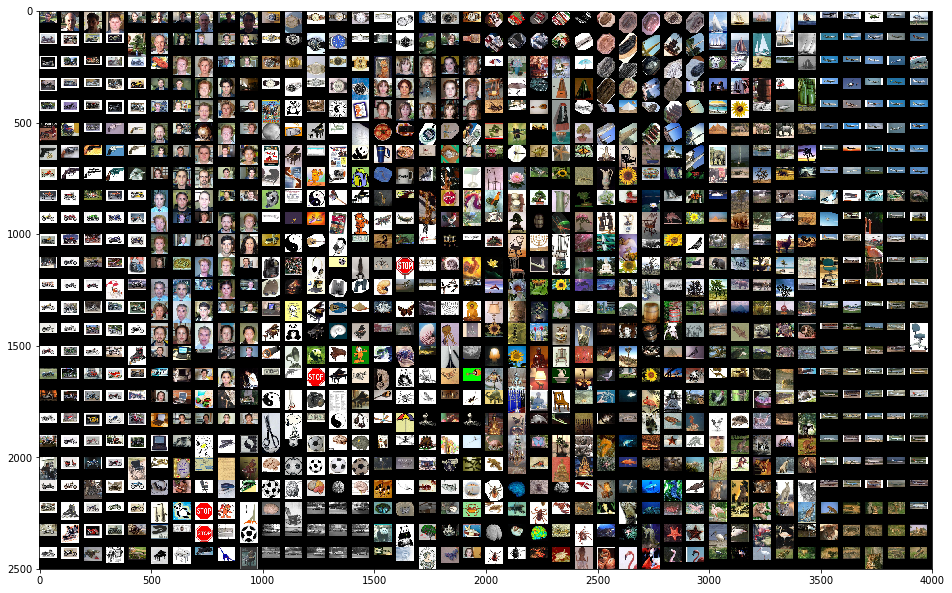

In [18]:
tile_width = 100
tile_height = 100

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = tile_width / tile_height

grid_image = Image.new('RGB', (full_width, full_height), (0, 0, 0, 255))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = tile.width / tile.height
    tile = tile.resize((int(0.8 * tile_width), int(0.8 * tile_height / tile_ar)), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

plt.figure(figsize = (16,12))
plt.imshow(grid_image)

In [19]:
sum_squared = []

K = range(1, 30)

for i in K:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(embedding_scaled)
    sum_squared.append(kmeans.inertia_)

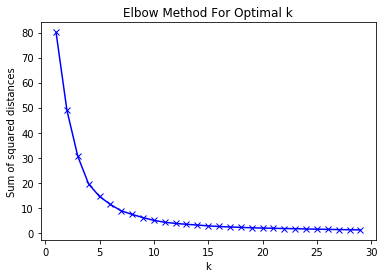

In [20]:
plt.plot(K, sum_squared, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show() 

In [21]:
kmeans = KMeans(n_clusters=30)
clusters = kmeans.fit_predict(embedding_scaled)

In [22]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5).fit(embedding_scaled)
_, closest = neighbors.kneighbors(kmeans.cluster_centers_)

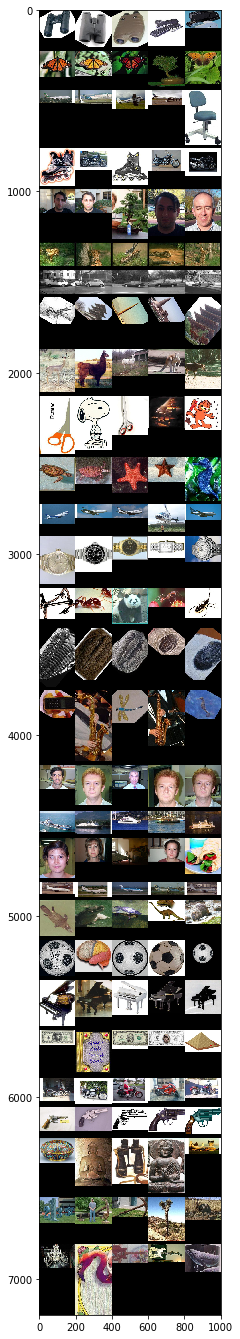

In [23]:
img_width = 200

grid_image = Image.new('RGB', (5 * img_width, len(closest) * 240), (0, 0, 0, 255))

max_height = 0
for cluster_row in closest:
    max_height_temp = 0
    xpos = 0
    for col_num in cluster_row:
        img = Image.open(images[col_num])
        img_ar = img.width / img.height
        img = img.resize((img_width, int(img_width / img_ar)), Image.ANTIALIAS)
        max_height_temp = max(max_height_temp, img.height)
        grid_image.paste(img, (xpos, max_height))
        xpos = xpos + img.width
    max_height = max_height + max_height_temp + 20 # adding 20 pixel margin

plt.figure(figsize = (32,24))
plt.imshow(grid_image)